# Neural Network Model for Endangered Language Classification
**Description**: This notebook expands the baseline model by implementing a neural network classification on endangered languages.
We'll evaluate both the **granular level labels** and the **grouped level labels** to compare effectiveness.
- Granular labels (individual endangered categories)
- Grouped labels (combined into broader categories like "At Risk" or "Highly Endangered").

*Note*: According to the 'Final Project Guidelines', "If you implement a linear regression model, logistic
regression model, or any neural network, all code must be written in TensorFlow". Thus, this model uses TensorFlow. 

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import keras_tuner as kt
from tensorflow import keras
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

2025-08-03 17:16:33.015096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Step 1: Load the final dataset, which is now a parquet file

In [2]:
df = pd.read_parquet('Data Cleaning/final_dataset2.parquet')

### Step 2: Define Function to Combine Endangered Levels (for grouped classification)

In [3]:
# Create a grouped version of the endangered levels
def combine_endangered_classes(level):
    if level in ['Severely Endangered', 'Critically Endangered']:
        return 'Highly Endangered'
    elif level in ['Threatened', 'Vulnerable', 'At risk']:
        return 'At Risk'
    else:
        return level

df_granular = df.copy()
df_grouped = df.copy()
df_grouped['level'] = df_grouped['level'].apply(combine_endangered_classes)

### Step 3: Define Function to Prepare features with Engineering

In [4]:
def prepare_features_with_engineering(df):
    """
    Prepare features with additional feature engineering
    """
    # Create copy to avoid modifying original
    df_feat = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['speakers', 'official', 'regional', 'minority', 'national', 
                   'widely_spoken', 'country_count', 'max_urbanization', 
                   'max_internet_use']
    
    for col in numeric_cols:
        if col in df_feat.columns:
            df_feat[col] = pd.to_numeric(df_feat[col], errors='coerce').fillna(0)
    
    # Add ratio features
    df_feat['urbanization_internet_product'] = df_feat['max_urbanization'] * df_feat['max_internet_use']
    df_feat['official_national_sum'] = df_feat['official'] + df_feat['national']
    df_feat['minority_regional_sum'] = df_feat['minority'] + df_feat['regional']
    
    # Log transform skewed features
    df_feat['log_speakers'] = np.log1p(df_feat['speakers'])
    
    # Interaction features
    df_feat['speakers_urbanization'] = df_feat['speakers'] * df_feat['max_urbanization']
    df_feat['speakers_internet'] = df_feat['speakers'] * df_feat['max_internet_use']
    
    # Replace any infinities or NaNs
    df_feat = df_feat.replace([np.inf, -np.inf], 0)
    df_feat = df_feat.fillna(0)
    
    return df_feat

### Step 4: Define Function to Handle Class Imbalance

In [5]:
def handle_class_imbalance(X_train, y_train, method='class_weight'):
    """
    Handle class imbalance using available methods
    """
    try:
        from imblearn.over_sampling import SMOTE, ADASYN
        from imblearn.combine import SMOTETomek
        HAS_IMBALANCED_LEARN = True
    except ImportError:
        HAS_IMBALANCED_LEARN = False
        print("imbalanced-learn not available. Install with: pip install imbalanced-learn")

    if HAS_IMBALANCED_LEARN and method == 'smote':
        smote = SMOTE(random_state=42, k_neighbors=min(5, min(np.bincount(y_train)) - 1))
        return smote.fit_resample(X_train, y_train)
    else:
        # Return original data if SMOTE not available
        return X_train, y_train

### Step 5: Train Neural Network

In [6]:
def train_baseline_nn_tensorflow(df, label_name=""):
    """
    Train baseline neural network in TensorFlow/Keras with proper preprocessing
    and train/val/test split.
    """

    print("\nTraining Neural Network in TensorFlow...")

    # Prepare features with feature engineering function
    df_feat = prepare_features_with_engineering(df)

    # Select feature columns
    feature_cols = list(df.columns[4:12]) + ['language_tld', 'wikipedia_pages'] + [
        'digital_presence_ratio', 'urbanization_internet_product', 
        'official_national_sum', 'minority_regional_sum',
        'log_speakers', 'log_wikipedia', 'log_tld_domains',
        'speakers_urbanization', 'speakers_internet'
    ]
    feature_cols = [col for col in feature_cols if col in df_feat.columns]

    X = df_feat[feature_cols].values.astype(np.float32)
    y = df_feat['level'].values

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split: 80% trainval, 20% test
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )
    # Split trainval: 75% train, 25% val (train=60%, val=20%)
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Convert labels to categorical for Keras
    num_classes = len(np.unique(y_encoded))
    y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

    # Build a simple NN model
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Early stopping callback
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=2
    )

    # Evaluate
    train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)

    print(f"\nTraining Accuracy: {train_acc:.3f}")
    print(f"Validation Accuracy: {val_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")

    # Predictions for classification report/ confusion matrix
    y_test_pred_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)

    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_test_pred)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_labels, y_pred_labels))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Neural Network {label_name} (Test Set)")
    plt.show()

    return model, scaler, le, feature_cols, history, (X_train, X_val, X_test), (y_train, y_val, y_test)


## Baseline Neural Network Model (no tuning)
Granular levels

- Training Accuracy: 75.4%
- Validation Accuracy: 72.0%
- Test Accuracy: 72.8%
- Notes: The model performs well on Critically Endangered, Endangered, Extinct, and Not Endangered, but struggles with At Risk and Severely Endangered, which show lower F1 scores of 0.33 and 0.48.

Grouped Levels

- Training Accuracy: 86.5%
- Validation Accuracy: 89.2%
- Test Accuracy: 87.6%
- Notes: Performance improves across all classes, with especially strong results for At Risk (F1 = 0.92), Highly Endangered (0.86), and Not Endangered (1.00). This suggests improved generalization and easier classification boundaries with grouped labels.

### Step 5.1: Train on Granular Labels

Training Neural Network on Granular Labels

Training Neural Network in TensorFlow...
Epoch 1/100
54/54 - 2s - 28ms/step - accuracy: 0.3182 - loss: 1.8919 - val_accuracy: 0.4303 - val_loss: 1.6471
Epoch 2/100
54/54 - 0s - 3ms/step - accuracy: 0.4361 - loss: 1.5375 - val_accuracy: 0.4739 - val_loss: 1.3819
Epoch 3/100
54/54 - 0s - 3ms/step - accuracy: 0.4814 - loss: 1.3604 - val_accuracy: 0.5436 - val_loss: 1.2292
Epoch 4/100
54/54 - 0s - 3ms/step - accuracy: 0.5174 - loss: 1.2586 - val_accuracy: 0.5610 - val_loss: 1.1495
Epoch 5/100
54/54 - 0s - 3ms/step - accuracy: 0.5470 - loss: 1.1584 - val_accuracy: 0.6272 - val_loss: 1.0998
Epoch 6/100
54/54 - 0s - 3ms/step - accuracy: 0.5528 - loss: 1.1596 - val_accuracy: 0.6220 - val_loss: 1.0713
Epoch 7/100
54/54 - 0s - 3ms/step - accuracy: 0.5813 - loss: 1.1135 - val_accuracy: 0.6098 - val_loss: 1.0589
Epoch 8/100
54/54 - 0s - 3ms/step - accuracy: 0.5883 - loss: 1.0894 - val_accuracy: 0.6237 - val_loss: 1.0285
Epoch 9/100
54/54 - 0s - 3ms/step 

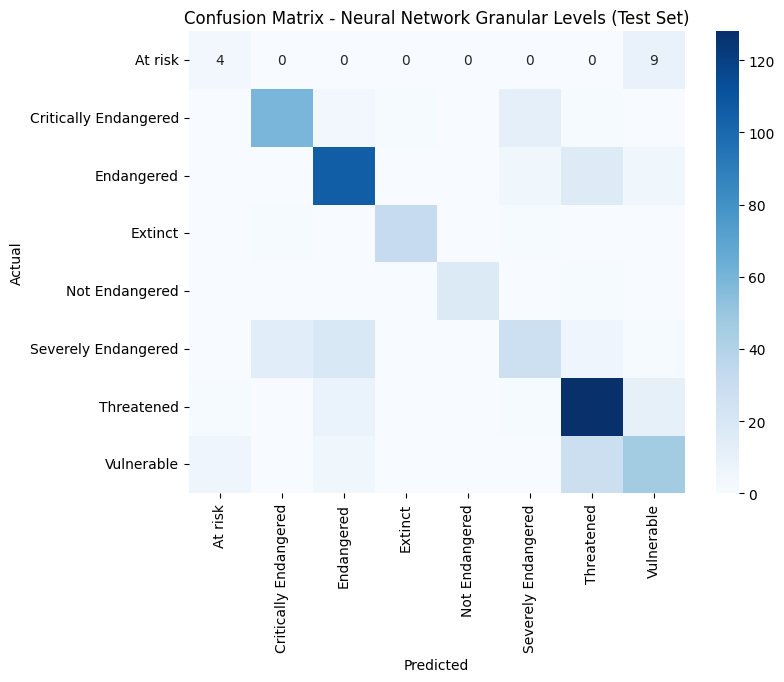

In [7]:
# Train on Granular Labels
print("Training Neural Network on Granular Labels")
model_granular, scaler_granular, le_granular, features, history_granular, (X_train_r, X_val_r, X_test_r), (y_train_r, y_val_r, y_test_r) = train_baseline_nn_tensorflow(df_granular, label_name="Granular Levels")

### Step 5.2: Train on Grouped Labels

Training Neural Network on Grouped Labels

Training Neural Network in TensorFlow...
Epoch 1/100
54/54 - 1s - 23ms/step - accuracy: 0.5552 - loss: 1.2974 - val_accuracy: 0.6916 - val_loss: 0.9833
Epoch 2/100
54/54 - 0s - 3ms/step - accuracy: 0.6498 - loss: 0.9969 - val_accuracy: 0.7230 - val_loss: 0.7827
Epoch 3/100
54/54 - 0s - 3ms/step - accuracy: 0.6847 - loss: 0.8823 - val_accuracy: 0.7213 - val_loss: 0.6802
Epoch 4/100
54/54 - 0s - 3ms/step - accuracy: 0.7033 - loss: 0.7677 - val_accuracy: 0.7578 - val_loss: 0.6284
Epoch 5/100
54/54 - 0s - 3ms/step - accuracy: 0.7207 - loss: 0.7268 - val_accuracy: 0.7735 - val_loss: 0.5906
Epoch 6/100
54/54 - 0s - 3ms/step - accuracy: 0.7445 - loss: 0.6770 - val_accuracy: 0.7892 - val_loss: 0.5612
Epoch 7/100
54/54 - 0s - 3ms/step - accuracy: 0.7398 - loss: 0.6804 - val_accuracy: 0.7997 - val_loss: 0.5435
Epoch 8/100
54/54 - 0s - 3ms/step - accuracy: 0.7689 - loss: 0.6417 - val_accuracy: 0.8014 - val_loss: 0.5265
Epoch 9/100
54/54 - 0s - 3ms/step -

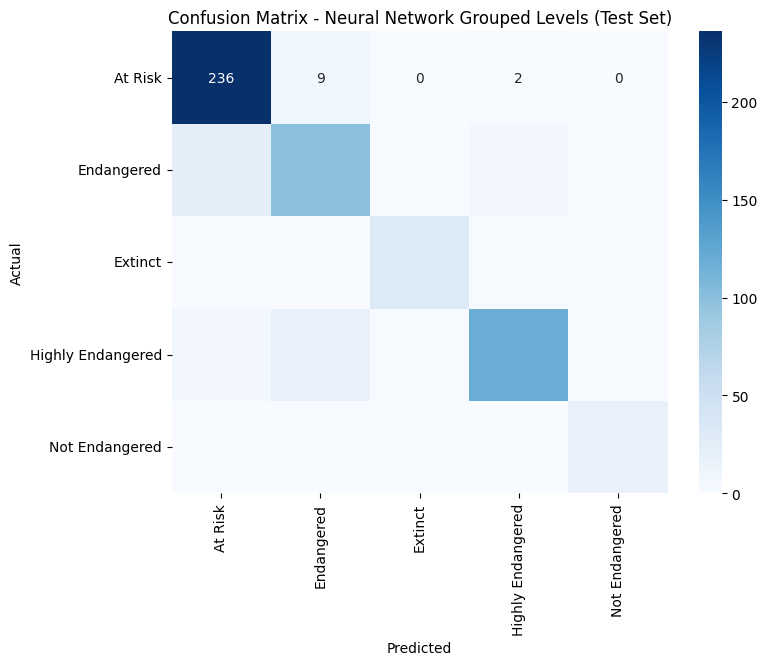

In [8]:
# Train on Grouped Labels
print("Training Neural Network on Grouped Labels")
model_grouped, scaler_grouped, le_grouped, features, history_grouped, (X_train_g, X_val_g, X_test_g), (y_train_g, y_val_g, y_test_g) = train_baseline_nn_tensorflow(df_grouped, label_name="Grouped Levels")

### Feature Importance Using Permutation

In [9]:
def permutation_importance(model, X, y, feature_names, scaler=None, metric=accuracy_score, n_repeats=5, seed=42):
    rng = np.random.default_rng(seed)

    if scaler:
        X = scaler.transform(X)
    baseline_preds = np.argmax(model.predict(X), axis=1)
    baseline_score = metric(y, baseline_preds)

    importances = []
    for i in range(X.shape[1]):
        scores = []
        for _ in range(n_repeats):
            X_permuted = X.copy()
            rng.shuffle(X_permuted[:, i])
            preds = np.argmax(model.predict(X_permuted), axis=1)
            score = metric(y, preds)
            scores.append(baseline_score - score)
        importances.append(np.mean(scores))

    return pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })

def compare_permutation_importance(
    model_grouped, X_test_g, y_test_g, scaler_grouped,
    model_granular, X_test_r, y_test_r, scaler_granular,
    feature_names, n_repeats=5
):
    importance_grouped = permutation_importance(
        model_grouped, X_test_g, y_test_g, feature_names, scaler=scaler_grouped, n_repeats=n_repeats
    )
    importance_granular = permutation_importance(
        model_granular, X_test_r, y_test_r, feature_names, scaler=scaler_granular, n_repeats=n_repeats
    )
    merged = pd.merge(
        importance_grouped.rename(columns={'importance': 'Grouped'}),
        importance_granular.rename(columns={'importance': 'Granular'}),
        on='feature'
    ).sort_values(by='Grouped', ascending=False)

    plt.figure(figsize=(8, 6))
    bar_width = 0.4
    indices = np.arange(len(merged))

    plt.barh(indices + bar_width / 2, merged['Grouped'], height=bar_width, label='Grouped', color='mediumpurple')
    plt.barh(indices - bar_width / 2, merged['Granular'], height=bar_width, label='Granular', color='lightseagreen')

    plt.yticks(indices, merged['feature'], fontsize=10)
    plt.xlabel('Decrease in Accuracy (Importance)', fontsize=12)
    plt.title('Permutation Feature Importance:(Baseline NN)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()

    plt.savefig('feature_importance_grouped_vs_granular.png', dpi=300)
    plt.show()

    print("\nTop 10 Features by Grouped Model:")
    print(merged[['feature', 'Grouped']].head(10).to_string(index=False))

    return merged


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


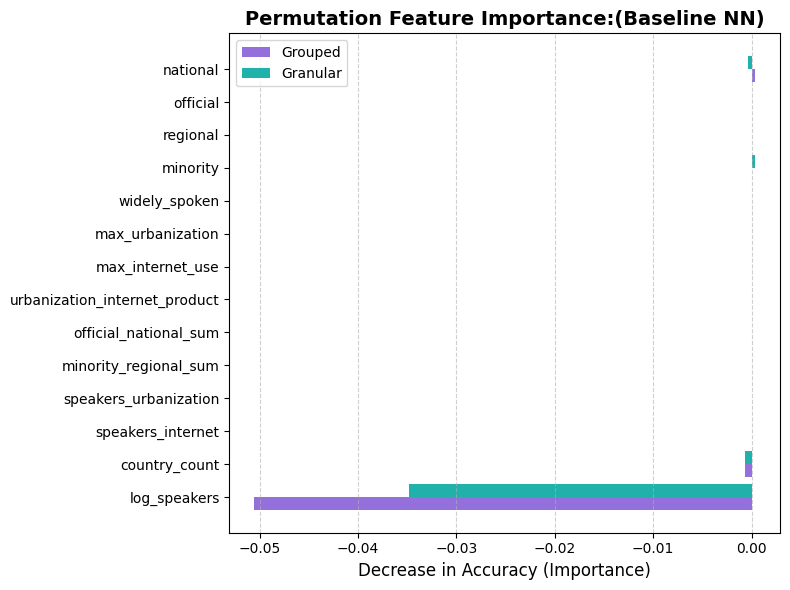


Top 10 Features by Grouped Model:
                      feature  Grouped
                     national 0.000348
                     official 0.000000
                     regional 0.000000
                     minority 0.000000
                widely_spoken 0.000000
             max_urbanization 0.000000
             max_internet_use 0.000000
urbanization_internet_product 0.000000
        official_national_sum 0.000000
        minority_regional_sum 0.000000


In [10]:
importance_comparison_df = compare_permutation_importance(
    model_grouped, X_test_g, y_test_g, scaler_grouped,
    model_granular, X_test_r, y_test_r, scaler_granular,
    features, n_repeats=5
)


### Step 6: Run Keras Tuner to find the best hyperparameters

In [23]:
import tensorflow.keras.backend as K

def build_model(hp, num_classes):
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train_g.shape[1],)))

    model.add(keras.layers.Dense(
        hp.Int("units_1", min_value=64, max_value=256, step=32),
        activation='relu'
    ))
    model.add(keras.layers.Dropout(hp.Float("dropout_1", 0.2, 0.5, step=0.1)))

    model.add(keras.layers.Dense(
        hp.Int("units_2", min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(keras.layers.Dropout(hp.Float("dropout_2", 0.2, 0.5, step=0.1)))

    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("lr", [1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [24]:
num_classes_grouped = len(np.unique(y_train_g))
num_classes_granular = len(np.unique(y_train_r))

def build_model_grouped(hp):
    return build_model(hp, num_classes_grouped)

def build_model_granular(hp):
    return build_model(hp, num_classes_granular)

# Tuner for grouped
tuner_grouped = kt.RandomSearch(
    build_model_grouped,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='grouped_language_tuning'
)

# Tuner for granular
tuner_granular = kt.RandomSearch(
    build_model_granular,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner_dir',
    project_name='granular_language_tuning'
)


In [25]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Run tuner for grouped labels
print("Starting tuning for grouped labels:")
tuner_grouped.search(
    X_train_g, y_train_g,
    epochs=50,
    validation_data=(X_val_g, y_val_g),
    callbacks=[early_stop],
    verbose=2
)

print("Best hyperparameters for grouped:")
best_hp_grouped = tuner_grouped.get_best_hyperparameters(num_trials=1)[0]
print(best_hp_grouped.values)

# Get best grouped model
best_model_grouped = tuner_grouped.get_best_models(num_models=1)[0]

# Clear session to free memory
keras.backend.clear_session()

# Run tuner for granular labels
print("\nStarting tuning for granular labels:")
tuner_granular.search(
    X_train_r, y_train_r,
    epochs=50,
    validation_data=(X_val_r, y_val_r),
    callbacks=[early_stop],
    verbose=2
)

print("Best hyperparameters for granular:")
best_hp_granular = tuner_granular.get_best_hyperparameters(num_trials=1)[0]
print(best_hp_granular.values)

# Get best granular model
best_model_granular = tuner_granular.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 00m 10s]
val_accuracy: 0.6219512224197388

Best val_accuracy So Far: 0.7177700400352478
Total elapsed time: 00h 01m 41s
Best hyperparameters for granular:
{'units_1': 64, 'dropout_1': 0.30000000000000004, 'units_2': 96, 'dropout_2': 0.4, 'lr': 0.001}


## Tuned Neural Network Model
Granular levels

- Training Accuracy: 75.1%
- Validation Accuracy: 71.8%
- Test Accuracy: 74.2%
- Notes: Slight decrease in validation accuracy compared to baseline (72.0% → 71.8%), but test accuracy improved slightly (72.8% → 74.2%). Improved F1 scores for some challenging classes, though the "At Risk" class still shows low recall (0.15 vs. baseline recall ~0.31). Other classes like Critically Endangered, Endangered, Extinct, and Not Endangered maintain strong performance. The "Severely Endangered" recall remains modest and similar to baseline.

Grouped levels

- Training Accuracy: 86.2%
- Validation Accuracy: 88.7%
- Test Accuracy: 85.7%
- Notes: Slight decrease in test accuracy compared to baseline (87.6% → 85.7%), but overall performance remains strong. Recall for the "At Risk" class stays high (~0.95), consistent with baseline, and other classes maintain stable precision and recall. This indicates the model generalizes well with grouped labels, making classification easier and reliable across classes.

### Step 7: Helper function to apply best parameters

In [28]:
def train_tuned_nn_tensorflow(df, best_hp, label_name=""):
    """
    Train neural network using best hyperparameters from tuning,
    keeping all baseline steps but adjusting model architecture and optimizer accordingly,
    and handling class imbalance via resampling.
    """

    print("\nTraining Tuned Neural Network in TensorFlow...")

    # Prepare features with feature engineering function
    df_feat = prepare_features_with_engineering(df)

    # Select feature columns
    feature_cols = list(df.columns[4:12]) + ['language_tld', 'wikipedia_pages'] + [
        'digital_presence_ratio', 'urbanization_internet_product', 
        'official_national_sum', 'minority_regional_sum',
        'log_speakers', 'log_wikipedia', 'log_tld_domains',
        'speakers_urbanization', 'speakers_internet'
    ]
    feature_cols = [col for col in feature_cols if col in df_feat.columns]

    X = df_feat[feature_cols].values.astype(np.float32)
    y = df_feat['level'].values

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Split into train/val/test sets same as baseline
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, stratify=y_trainval, random_state=42
    )

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    # Handle class imbalance with SMOTE or fallback
    X_train_resampled, y_train_resampled = handle_class_imbalance(X_train, y_train, method='smote')

    # One-hot encode targets for categorical_crossentropy
    num_classes = len(np.unique(y_encoded))
    y_train_cat = tf.keras.utils.to_categorical(y_train_resampled, num_classes)
    y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
    y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

    # Build model using best hyperparameters
    model = models.Sequential([
        layers.Input(shape=(X_train.shape[1],)),

        layers.Dense(best_hp.get('units_1'), activation='relu'),
        layers.Dropout(best_hp.get('dropout_1')),

        layers.Dense(best_hp.get('units_2'), activation='relu'),
        layers.Dropout(best_hp.get('dropout_2')),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=best_hp.get('lr')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


    # Early stopping callback
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train model on resampled data
    history = model.fit(
        X_train_resampled, y_train_cat,
        validation_data=(X_val, y_val_cat),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=2
    )

    # Evaluate
    train_loss, train_acc = model.evaluate(X_train_resampled, y_train_cat, verbose=0)
    val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=0)

    print(f"\nTraining Accuracy: {train_acc:.3f}")
    print(f"Validation Accuracy: {val_acc:.3f}")
    print(f"Test Accuracy: {test_acc:.3f}")

    # Predictions for classification report/confusion matrix
    y_test_pred_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)

    y_test_labels = le.inverse_transform(y_test)
    y_pred_labels = le.inverse_transform(y_test_pred)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test_labels, y_pred_labels))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - Tuned Neural Network {label_name} (Test Set)")
    plt.show()

    return model, scaler, le, feature_cols, history, (X_train_resampled, X_val, X_test), (y_train_resampled, y_val, y_test)

### Granular Labels Tuned NN


Training Tuned Neural Network in TensorFlow...
imbalanced-learn not available. Install with: pip install imbalanced-learn
Epoch 1/100
54/54 - 1s - 23ms/step - accuracy: 0.2735 - loss: 1.9007 - val_accuracy: 0.3868 - val_loss: 1.7129
Epoch 2/100
54/54 - 0s - 3ms/step - accuracy: 0.4001 - loss: 1.6396 - val_accuracy: 0.4686 - val_loss: 1.4873
Epoch 3/100
54/54 - 0s - 3ms/step - accuracy: 0.4501 - loss: 1.4987 - val_accuracy: 0.5052 - val_loss: 1.3344
Epoch 4/100
54/54 - 0s - 3ms/step - accuracy: 0.4983 - loss: 1.3393 - val_accuracy: 0.5505 - val_loss: 1.2287
Epoch 5/100
54/54 - 0s - 3ms/step - accuracy: 0.5006 - loss: 1.2720 - val_accuracy: 0.5610 - val_loss: 1.1530
Epoch 6/100
54/54 - 0s - 3ms/step - accuracy: 0.5221 - loss: 1.2256 - val_accuracy: 0.5784 - val_loss: 1.1037
Epoch 7/100
54/54 - 0s - 3ms/step - accuracy: 0.5563 - loss: 1.1963 - val_accuracy: 0.5976 - val_loss: 1.0674
Epoch 8/100
54/54 - 0s - 3ms/step - accuracy: 0.5645 - loss: 1.1615 - val_accuracy: 0.6394 - val_loss: 1.0

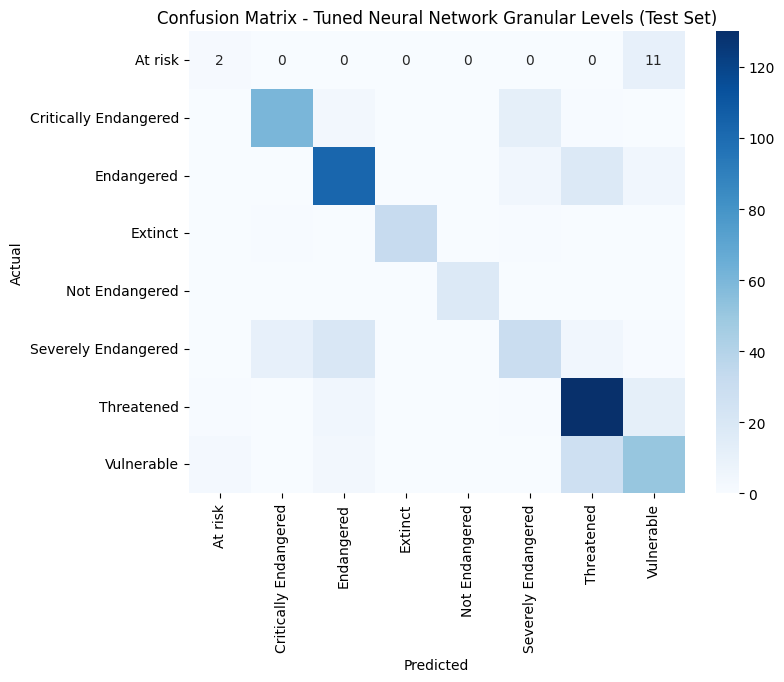

(<Sequential name=sequential_1, built=True>,
 StandardScaler(),
 LabelEncoder(),
 ['official',
  'regional',
  'minority',
  'national',
  'widely_spoken',
  'country_count',
  'max_urbanization',
  'max_internet_use',
  'urbanization_internet_product',
  'official_national_sum',
  'minority_regional_sum',
  'log_speakers',
  'speakers_urbanization',
  'speakers_internet'],
 (array([[-0.0697828 , -0.0564093 , -0.05667383, ...,  0.07183504,
          -0.05881407, -0.06100655],
         [-0.0697828 , -0.0564093 , -0.05667383, ..., -1.7599345 ,
          -0.05883293, -0.0610275 ],
         [-0.0697828 , -0.0564093 , -0.05667383, ..., -0.7261707 ,
          -0.05883204, -0.06102652],
         ...,
         [-0.0697828 , -0.0564093 , -0.05667383, ..., -0.6078029 ,
          -0.05883251, -0.06102682],
         [-0.0697828 , -0.0564093 , -0.05667383, ...,  0.73066896,
          -0.05861302, -0.06082111],
         [-0.0697828 , -0.0564093 , -0.05667383, ..., -0.54651743,
          -0.05883173,

In [29]:
best_hp = tuner_granular.get_best_hyperparameters(1)[0]

train_tuned_nn_tensorflow(
    df_granular,
    best_hp,
    label_name="Granular Levels"
)


### Grouped Labels Tuned NN


Training Tuned Neural Network in TensorFlow...
imbalanced-learn not available. Install with: pip install imbalanced-learn
Epoch 1/100
54/54 - 1s - 22ms/step - accuracy: 0.5738 - loss: 1.1987 - val_accuracy: 0.6829 - val_loss: 0.8798
Epoch 2/100
54/54 - 0s - 3ms/step - accuracy: 0.6911 - loss: 0.8427 - val_accuracy: 0.7683 - val_loss: 0.6814
Epoch 3/100
54/54 - 0s - 3ms/step - accuracy: 0.7271 - loss: 0.7432 - val_accuracy: 0.8066 - val_loss: 0.5971
Epoch 4/100
54/54 - 0s - 3ms/step - accuracy: 0.7607 - loss: 0.6596 - val_accuracy: 0.8188 - val_loss: 0.5320
Epoch 5/100
54/54 - 0s - 3ms/step - accuracy: 0.7619 - loss: 0.6403 - val_accuracy: 0.8467 - val_loss: 0.5179
Epoch 6/100
54/54 - 0s - 3ms/step - accuracy: 0.7828 - loss: 0.6043 - val_accuracy: 0.8467 - val_loss: 0.4975
Epoch 7/100
54/54 - 0s - 3ms/step - accuracy: 0.7834 - loss: 0.5895 - val_accuracy: 0.8484 - val_loss: 0.4959
Epoch 8/100
54/54 - 0s - 3ms/step - accuracy: 0.7851 - loss: 0.5957 - val_accuracy: 0.8659 - val_loss: 0.4

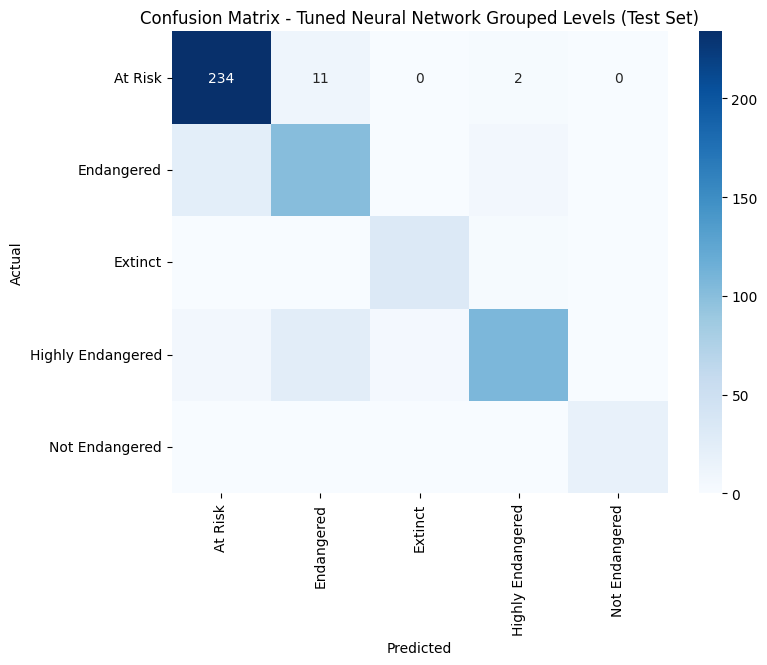

(<Sequential name=sequential_2, built=True>,
 StandardScaler(),
 LabelEncoder(),
 ['official',
  'regional',
  'minority',
  'national',
  'widely_spoken',
  'country_count',
  'max_urbanization',
  'max_internet_use',
  'urbanization_internet_product',
  'official_national_sum',
  'minority_regional_sum',
  'log_speakers',
  'speakers_urbanization',
  'speakers_internet'],
 (array([[-0.06929637, -0.06189688, -0.06353569, ...,  0.66543084,
          -0.05814857, -0.05998206],
         [-0.06929637, -0.06189688, -0.06353569, ...,  1.5264308 ,
          -0.0555322 , -0.0581498 ],
         [-0.06929637, -0.06189688, -0.06353569, ..., -0.32027626,
          -0.05827483, -0.06013645],
         ...,
         [-0.06929637, -0.06189688, -0.06353569, ..., -0.13539788,
          -0.05827327, -0.06013647],
         [-0.06929637, -0.06189688, -0.06353569, ...,  0.9051119 ,
          -0.05791789, -0.05973557],
         [-0.06929637, -0.06189688, -0.06353569, ..., -0.56644523,
          -0.058279  ,

In [30]:
best_hp_grouped = tuner_grouped.get_best_hyperparameters(1)[0]

train_tuned_nn_tensorflow(
    df_grouped,
    best_hp_grouped,
    label_name="Grouped Levels"
)

### Summary: 
The tuned granular model shows a slight drop in validation accuracy (72.0% to 71.8%) but improves test accuracy from 72.8% to 74.2%. While the "At Risk" class recall remains low, performance on other classes remains stable, with "Severely Endangered" recall similar to baseline. For grouped levels, the tuned model experiences a small decrease in test accuracy (87.6% to 85.7%) but maintains high recall for the important "At Risk" class and stable precision and recall across other classes, demonstrating strong generalization.

In [31]:
print(best_hp_grouped.values)


{'units_1': 160, 'dropout_1': 0.30000000000000004, 'units_2': 128, 'dropout_2': 0.2, 'lr': 0.001}


In [32]:
print(best_hp_granular.values)

{'units_1': 64, 'dropout_1': 0.30000000000000004, 'units_2': 96, 'dropout_2': 0.4, 'lr': 0.001}


| Class                | Baseline Granular (P / R / F1) | Tuned Granular (P / R / F1) | Baseline Grouped (P / R / F1) | Tuned Grouped (P / R / F1) |
|----------------------|--------------------------------|-----------------------------|-------------------------------|----------------------------|
| At Risk              | 0.36 / 0.31 / 0.33             | 0.33 / 0.15 / 0.21          | 0.88 / 0.96 / 0.92            | 0.89 / 0.95 / 0.92         |
| Critically Endangered | 0.80 / 0.77 / 0.78             | 0.83 / 0.78 / 0.81          | —                             | —                          |
| Endangered           | 0.74 / 0.80 / 0.77             | 0.76 / 0.79 / 0.77          | 0.79 / 0.76 / 0.77            | 0.74 / 0.77 / 0.75         |
| Extinct              | 0.97 / 0.94 / 0.96             | 1.00 / 0.94 / 0.97          | 0.97 / 0.94 / 0.96            | 0.86 / 0.94 / 0.90         |
| Not Endangered       | 1.00 / 0.94 / 0.97             | 1.00 / 1.00 / 1.00          | 1.00 / 1.00 / 1.00            | 1.00 / 1.00 / 1.00         |
| Severely Endangered   | 0.59 / 0.40 / 0.48             | 0.61 / 0.45 / 0.52          | —                             | —                          |
| Threatened           | 0.71 / 0.86 / 0.78             | 0.72 / 0.87 / 0.79          | —                             | —                          |
| Vulnerable           | 0.64 / 0.54 / 0.59             | 0.64 / 0.60 / 0.62          | —                             | —                          |
| Highly Endangered    | —                              | —                           | 0.91 / 0.82 / 0.86            | 0.91 / 0.74 / 0.82         |
